In [1]:
import domain_adapt_run.domain_adapt_run.constants as constants
cache_folder_name = 'kernel_mean_matching'
seed = 42

In [2]:
import numpy as np
np.random.seed(seed)
import python_utils.python_utils.basic as basic
import python_utils.python_utils.caching as caching
log_folder = '%s/%s' % (constants.cache_folder, cache_folder_name)
caching.init(constants.cache_folder, constants.which_hash, basic.archiver(log_folder))
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats
import cvxopt

* define dimensionality of distributions
* define 2 distributions - train and test.  have their pdf and sampling methods
* set number of train and test samples to generate
* define pairwise within and across train/test sample kernel distances, either directly via a function, or parameterize that function by the feature map
* use that kernel distance function to populate K and kappa in the optimization problem
* solve the optimization problem to get the B's
* compare B(x) to p_test(x) / p_train(x).  maybe plot scatter plot of B(x) vs that ratio

In [4]:
# define dimensionality of distributions
d = 1

In [5]:
# define train distribution
train_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=d))
train_pdf = train_dist.pdf
train_sample = train_dist.rvs

In [6]:
# define test distribution
test_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=d)+1.)
test_pdf = test_dist.pdf
test_sample = test_dist.rvs

In [7]:
# define number of samples to generate
num_train = 800
num_test = 800

In [8]:
# generate the samples
train_xs = [train_sample() for i in xrange(num_train)]
test_xs = [test_sample() for i in xrange(num_test)]

In [9]:
# define kernel function
def rbf(sigma, u, v):
    return np.exp(-np.linalg.norm(u-v) / (2*(sigma**2)))

kernel_f = functools.partial(rbf, .1)

In [10]:
# define hyperparameters
B_max = 100
eps = 0.00001

In [11]:
# define optimization problem
K = np.array([[kernel_f(train_x1,train_x2) for train_x1 in train_xs] for train_x2 in train_xs])
kappa = (float(num_train)/num_test) * np.sum(np.array([[kernel_f(test_x,train_x) for test_x in test_xs] for train_x in train_xs]), axis=1)

P = K
q = -1. * kappa
G_gt_0 = -np.eye(num_train)
h_gt_0 = np.zeros(num_train)
G_lt_B_max = np.eye(num_train)
h_lt_B_max = np.ones(num_train) * B_max
G_B_sum_lt = np.ones(num_train)
h_B_sum_lt = (1+eps) * num_test * np.ones(1)
G_B_sum_gt = -np.ones(num_train)
h_B_sum_gt = -(1-eps) * num_test * np.ones(1)
G = np.vstack((G_gt_0,G_lt_B_max,G_B_sum_lt,G_B_sum_gt))
(h_gt_0,h_lt_B_max,h_B_sum_lt,h_B_sum_gt)
h = np.hstack((h_gt_0,h_lt_B_max,h_B_sum_lt,h_B_sum_gt))

In [12]:
# solve
ans = cvxopt.solvers.qp(\
                  cvxopt.matrix(P,tc='d'),\
                  cvxopt.matrix(q,tc='d'),\
                  cvxopt.matrix(G,tc='d'),\
                  cvxopt.matrix(h,tc='d')\
                  )
B = np.array(ans['x'])
ans

     pcost       dcost       gap    pres   dres
 0: -3.0108e+03 -2.1111e+05  4e+06  6e-01  2e+01
 1: -2.6578e+03 -9.3452e+04  9e+04  1e-04  4e-03
 2: -2.7759e+03 -1.3218e+04  1e+04  1e-05  5e-04
 3: -3.2084e+03 -6.6698e+03  3e+03  3e-07  1e-05
 4: -3.3246e+03 -4.5846e+03  1e+03  9e-08  3e-06
 5: -3.3597e+03 -4.8358e+03  1e+03  6e-08  2e-06
 6: -3.4215e+03 -3.8070e+03  4e+02  1e-08  5e-07
 7: -3.4375e+03 -3.5243e+03  9e+01  9e-10  3e-08
 8: -3.4419e+03 -3.4565e+03  1e+01  3e-11  1e-09
 9: -3.4431e+03 -3.4461e+03  3e+00  4e-12  2e-10
10: -3.4434e+03 -3.4440e+03  6e-01  6e-13  2e-11
11: -3.4435e+03 -3.4436e+03  9e-02  7e-14  3e-12
12: -3.4435e+03 -3.4435e+03  1e-02  3e-15  1e-13
13: -3.4435e+03 -3.4435e+03  1e-03  2e-16  2e-15
Optimal solution found.


{'dual infeasibility': 2.2968317484070204e-15,
 'dual objective': -3443.5021516381266,
 'dual slack': 2.3040459752378604e-09,
 'gap': 0.0012855690071581236,
 'iterations': 13,
 'primal infeasibility': 2.052528957939046e-16,
 'primal objective': -3443.5008660691196,
 'primal slack': 0.0005986261566876834,
 'relative gap': 3.7333198310638063e-07,
 's': <1602x1 matrix, tc='d'>,
 'status': 'optimal',
 'x': <800x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 'z': <1602x1 matrix, tc='d'>}

In [13]:
# calculate true B's
true_B = test_pdf(train_xs) / train_pdf(train_xs)

In [14]:
# define plot constants
s = 2
max_lim = 10

/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


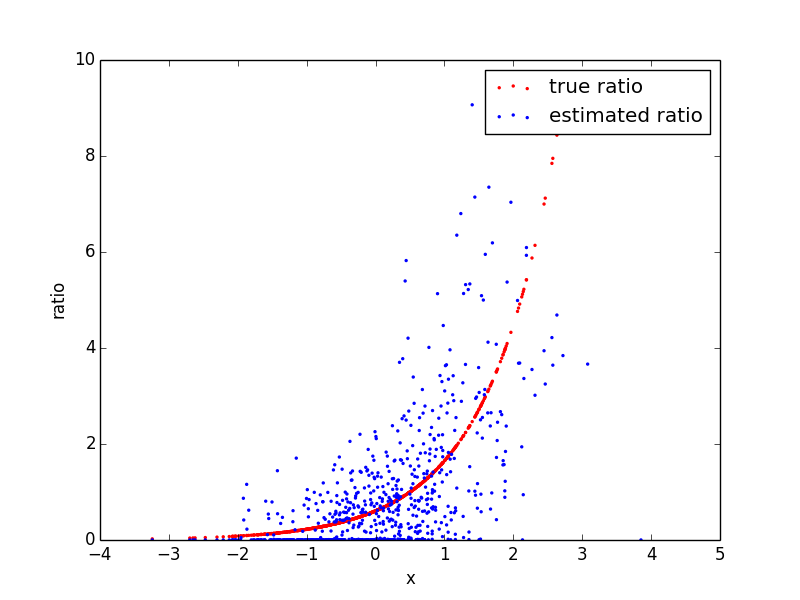

In [15]:
# plot 
fig, ax = plt.subplots()
ax.scatter(train_xs, true_B, s=s,color='red',label='true ratio')
ax.scatter(train_xs, B,s=s,color='blue',label='estimated ratio')
#ax.set_xlim((-max_lim,max_lim/2))
ax.set_ylim((0,max_lim))
ax.set_xlabel('x')
ax.set_ylabel('ratio')
ax.legend()
basic.display_fig_inline(fig)

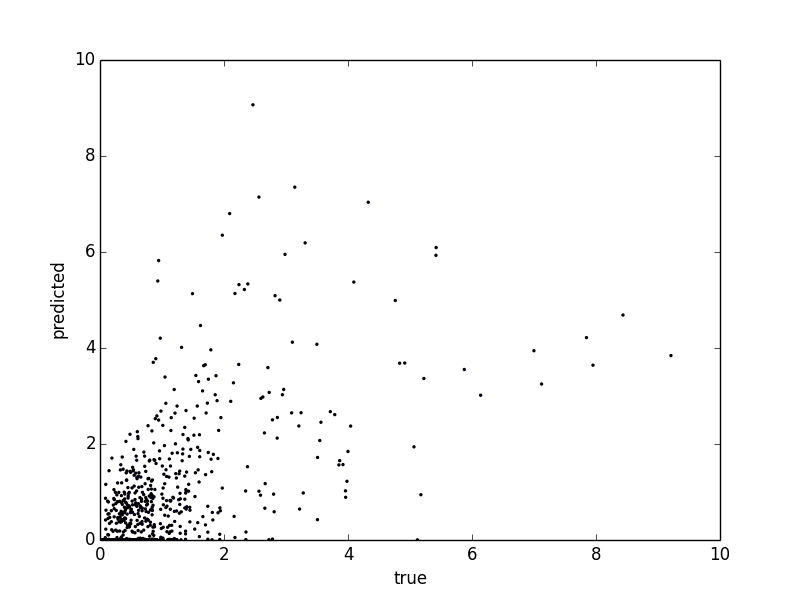

In [16]:
# plot scatterplot
fig, ax = plt.subplots()
ax.scatter(true_B,B, s=s)
ax.set_xlabel('true')
ax.set_ylabel('predicted')
ax.set_xlim((0,max_lim))
ax.set_ylim((0,max_lim))
basic.display_fig_inline(fig)